In [14]:
%matplotlib inline

In [15]:
import pandas as pd
import matplotlib.pyplot as pyPlot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [16]:
csv_input = pd.read_csv(filepath_or_buffer="./winter_randomForest.csv",
                        encoding="utf_8", sep=",")
features_df = pd.DataFrame()

# 目的変数
features_df['delay'] = csv_input['delay']

# 説明変数
features_df['access_num'] = csv_input['access_num']
features_df['snow_fall'] = csv_input['snow_fall'].fillna(method='ffill')
features_df['time'] = pd.Categorical(csv_input['time'])

In [17]:
X = features_df.loc[:, 'access_num':]
Y = features_df['delay']

# 学習データとテストデータの分離
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

# ランダムフォレストの作成
forest = RandomForestClassifier(min_samples_leaf=3, random_state=0)
forest.fit(X_train, Y_train)

# 評価
print('Train score: {}'.format(forest.score(X_train, Y_train)))
print('Test score: {}'.format(forest.score(X_test, Y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(Y_test, forest.predict(X_test))))
print('f1 score: {:.3f}'.format(f1_score(Y_test, forest.predict(X_test))))


Train score: 0.6229893652973618


Test score: 0.6169053884982096


Confusion matrix:
[[34048 15183]
 [20336 23149]]


f1 score: 0.566


([<matplotlib.axis.YTick at 0x110641cc0>,
 <a list of 3 Text yticklabel objects>)

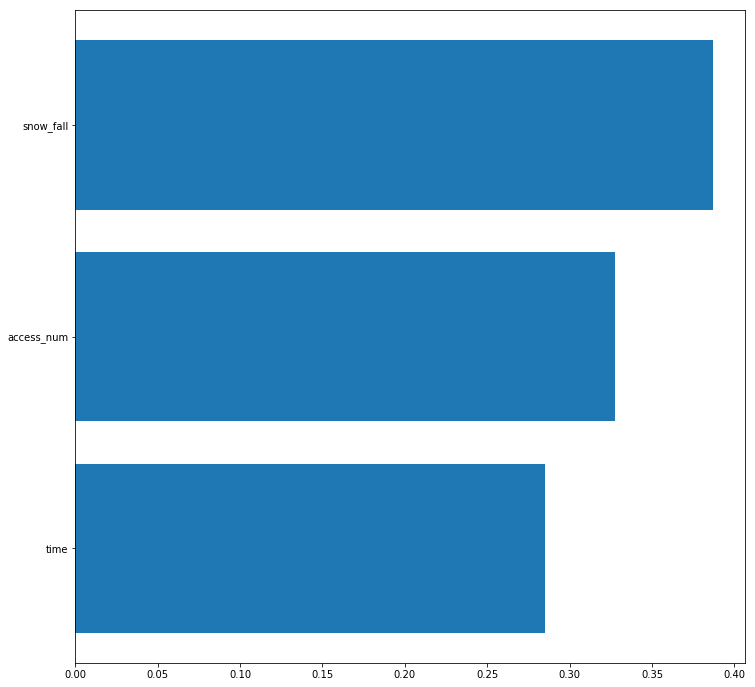

In [18]:
values, names = zip(*sorted(zip(forest.feature_importances_, X.columns)))

pyPlot.figure(figsize=(12,12))
pyPlot.barh(range(len(names)), values, align='center')
pyPlot.yticks(range(len(names)), names)